In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import seaborn as sns

%matplotlib inline

# Pull Data

In [2]:
#path = "C:/Users/Akis-/OneDrive/Masters/Web Economics/Data/"
path=""
#test_df = pd.read_csv(path+'test.csv')
train_df = pd.read_csv(path+'train.csv')
validation_df = pd.read_csv(path+'validation.csv')

In [3]:
budget=6250*1000
print("Our Budget is:",budget, "Fen")
print("To use over",validation_df.shape[0],"bid opportunities.")
BudPerBid=budget/validation_df.shape[0]
print("Budget / Bid Opportunity:",BudPerBid)

minBid=np.min(train_df["payprice"].values)-10
maxBid=np.max(train_df["payprice"].values)+100
custRange = np.arange(minBid+1, maxBid+2,10) # determines the range that bids should be in

Our Budget is: 6250000 Fen
To use over 303925 bid opportunities.
Budget / Bid Opportunity: 20.564283951632802


In [4]:
'''
Impressions = test_df.shape[0]
ImpressionsPerTeam = Impressions/30
AverageSpendPerImpression = 6250000/ImpressionsPerTeam
print("Total number of auctions:", Impressions)
print("Average Number Of Impressions per team:",ImpressionsPerTeam)
print("Average budget per impression",AverageSpendPerImpression)
'''

'\nImpressions = test_df.shape[0]\nImpressionsPerTeam = Impressions/30\nAverageSpendPerImpression = 6250000/ImpressionsPerTeam\nprint("Total number of auctions:", Impressions)\nprint("Average Number Of Impressions per team:",ImpressionsPerTeam)\nprint("Average budget per impression",AverageSpendPerImpression)\n'

In [5]:
'''meanPayPrice = train_df["bidprice"].mean()/1000
Impressions = test_df.shape[0]
totalSpend = Impressions * meanPayPrice
spendPerTeam = totalSpend/30 #30 is number of teams
percOfBudget = int(spendPerTeam*100/6250)
suggestedBudget = int(spendPerTeam*0.80/100)*100 #75 percent of their probable spend, to make sure everyone can reach their budget limit
print("Assuming that by training our models on the train set provided, our payprices will be similar to those of the train set:")
print("Pay price average in train set:",meanPayPrice)
print("Total number of auctions to be held in the competition:", Impressions)
print("These 2 figures tell us that a rough total of",int(totalSpend)," will be paid by all teams combined.")
print("Average spend of each team:", int(spendPerTeam),"which equals",percOfBudget,"% of their budget.")
print("Thus a budget of roughly 80% of their likely spend is suggested:",suggestedBudget,"CNY Fen")
'''

'meanPayPrice = train_df["bidprice"].mean()/1000\nImpressions = test_df.shape[0]\ntotalSpend = Impressions * meanPayPrice\nspendPerTeam = totalSpend/30 #30 is number of teams\npercOfBudget = int(spendPerTeam*100/6250)\nsuggestedBudget = int(spendPerTeam*0.80/100)*100 #75 percent of their probable spend, to make sure everyone can reach their budget limit\nprint("Assuming that by training our models on the train set provided, our payprices will be similar to those of the train set:")\nprint("Pay price average in train set:",meanPayPrice)\nprint("Total number of auctions to be held in the competition:", Impressions)\nprint("These 2 figures tell us that a rough total of",int(totalSpend)," will be paid by all teams combined.")\nprint("Average spend of each team:", int(spendPerTeam),"which equals",percOfBudget,"% of their budget.")\nprint("Thus a budget of roughly 80% of their likely spend is suggested:",suggestedBudget,"CNY Fen")\n'

In [6]:
pd.set_option('display.max_columns', None)

# Functions

### Plot Metrics by Constant Bidding Rate

In [7]:
def plotResults(resultsDataFrame):
    
    metrics = [resultsDataFrame['ConstValue'],resultsDataFrame['CTR'], resultsDataFrame['Clicks'], resultsDataFrame['Spend'], resultsDataFrame['CPM'], resultsDataFrame['CPC'], resultsDataFrame['Impressions']]
    metricNames = ['ConstValue','CTR','Clicks','Spend','CostPerMille','CostPerClick','Impressions']

    f, axarr = plt.subplots(len(metrics), sharex=True, figsize=(8, 14))
    i=0
    for metric in metrics:
        axarr[i].plot(custRange, metric)
        axarr[i].set_title(metricNames[i])
        axarr[i].axvline(x=228,color='red')
        axarr[i].axvline(x=278,color='red')
        i+=1

    axarr[i-1].set(xlabel="Constant Bid Value")

    # Bring subplots close to each other.
    f.subplots_adjust(wspace=0.3)
    
    
    useless = 0
    return useless

### Function to find best constant bidding value for a dataset

In [8]:
# dataframe pandas:                  data to find best value for
# metric string:                     metric that needs minimsing or maximising
# MaxMin "maximise"/"minimise":      Minimse or Maximise the metric
# minSpendPercentage [0,1]:          Minimum % of Budget we want to use
# plot boolean:                      plot results?

def FindConstant(dataframe,metric,MaxMin,minSpendPercentage,plot):
    
    minSpend=minSpendPercentage*dataframe.shape[0]*BudPerBid*3
    
    resultsDF = pd.DataFrame(columns=['ConstValue','CTR', 'Clicks', 'Spend', 'CPM', 'CPC', 'Impressions'])

    
    for ConstantBid in custRange:        
        resultsDF.loc[len(resultsDF)] = EvalConstBid(dataframe,ConstantBid,6250000,validation_df.shape[0])
    #print(resultsDF)
    if plot:
        plotResults(resultsDF)
    
    if MaxMin == "maximise":
        mIndex = resultsDF[metric].where(resultsDF['Spend'] >= minSpend).idxmax(axis=1, skipna=True)
    elif MaxMin == "minimise":
        mIndex = resultsDF[metric].where(resultsDF['Spend'] >= minSpend).idxmin(axis=1, skipna=True)
    else:
        print("Maximise or minimise?")
    
    print(resultsDF)
    constant = int(resultsDF['ConstValue'][mIndex])
    
    return constant

### Evaluate a constant bid value on a new set

In [9]:
def EvalConstBid(dataframe,constant,budget,size):
    
    AdjustedBudget=(budget/size)*dataframe.shape[0]
    print("AdjustedBudget is:",AdjustedBudget)
    tempData=dataframe.copy(True)
    tempData['ConstBid']=constant

    tempData['trueValues'] = np.where(tempData["payprice"]<tempData['ConstBid'],1,0)
    tempData['ModelPays'] = tempData['trueValues']*tempData['payprice']
    tempData['cumsum'] = tempData['ModelPays'].cumsum()
    lastRowToInclude = np.argmax(tempData['cumsum'].as_matrix()>AdjustedBudget)
    if lastRowToInclude==0:
        lastRowToInclude=tempData.shape[0]
    #print("lastRowToInclude",lastRowToInclude)
    
    shortData = tempData.head(lastRowToInclude).copy(True)
    trueValues = (0<shortData['ModelPays'])
    impressions = shortData[trueValues].shape[0]
    clicks = np.sum(shortData[trueValues]["click"].values)
    spend = np.sum(shortData[trueValues]["payprice"].values)
    CostPerClick = spend/clicks
    CostPerMille = spend*1000/(impressions)
    ClickThroughRate=(clicks*100)/impressions
    return [constant, ClickThroughRate, clicks, spend, CostPerMille, CostPerClick, impressions]


    #impressions = shortData.loc[shortData['ModelPays'] > 0].sum()
    #clicks = shortData.loc[shortData['ModelPays'] > 0 , 'click'].sum()
    #print("clicks:",clicks)

In [10]:
dataa = EvalConstBid(train_df,275,6250000,validation_df.shape[0])
print(dataa)

AdjustedBudget is: 49991383.565024264
[275, 0.06979007878932579, 456, 49991361, 76510.98734595676, 109630.17763157895, 653388]


### Bootstrap to combine above two functions

In [11]:
def Bootstrap(trainDF,repeats):
    BestBids=[]
    for n in range(1,repeats+1,1):
        print(n,"/",repeats,"...")
        #randomly assign 75% of data to dataSubset
        dataSubset = trainDF.sample(frac=0.75, replace=False)

        constant = FindConstant(dataSubset,'CTR','maximise',0.5,plot=False)

        CTR = EvalConstBid(dataSubset,constant)[1]
        #print("Constant value" ,constant, "gives CTR of:",CTR)
        BestBids.append(constant)
        counts = np.bincount(BestBids)
        BestBid = np.argmax(counts)
    
    return BestBid

### Evalute on a new data set (validation set)

# Main Code

In [12]:
dataSubset = train_df.sample(frac=0.70, replace=False)

AdjustedBudget is: 34993974.66480217


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in longlong_scalars


AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
AdjustedBudget is: 34993974.66480217
A

TypeError: cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>

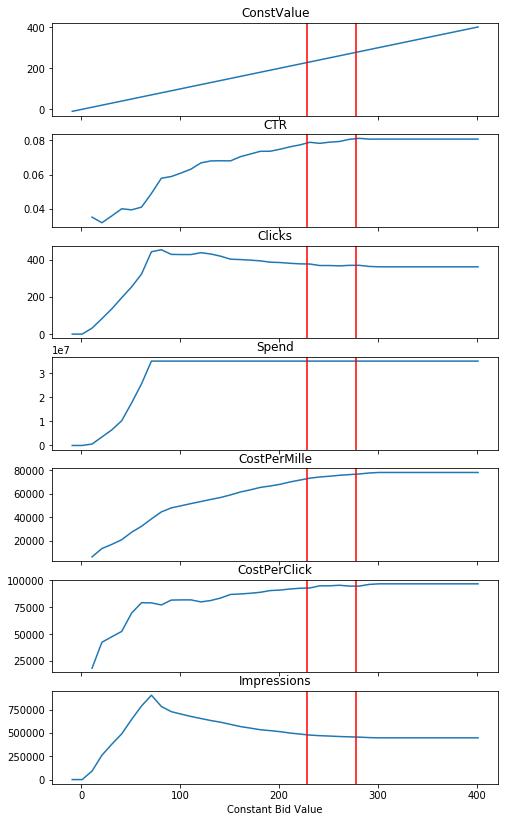

In [13]:
FindConstant(dataSubset,'CTR','maximise',0.5,plot=True)

This looks right when comparing to the graph below. We can see that the green graph is higher than the red for higher bid values. Thus the CTR will continue to increase the higher the bid constant.

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


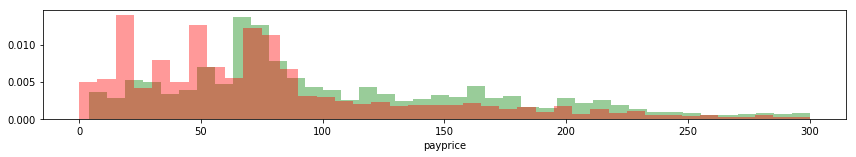

In [14]:
plt.figure(figsize = (12,6))


ax = plt.subplot(3,1,2)
sns.distplot(train_df.loc[train_df["click"] == 1, "payprice"], bins = 40, kde = False, norm_hist = True, color = "green")
ax = plt.subplot(3,1,2)
sns.distplot(train_df.loc[train_df["click"] == 0, "payprice"], bins = 40, kde = False, norm_hist = True, color = "red")

#ax = plt.subplot(3,1,3)
#sns.distplot(train.loc[train["click"] == 1, "BidPayDifference"], bins = 40, kde = False, norm_hist = True, color = "green")
#ax = plt.subplot(3,1,3)
#sns.distplot(train.loc[train["click"] == 0, "BidPayDifference"], bins = 40, kde = False, norm_hist = True, color = "red")

plt.tight_layout()

### Bootstrap to find best constant bidding value on train set

In [ ]:
BestBid = Bootstrap(train_df,repeats=5)

### Evaluate Strategy on Validation Set

In [ ]:
#BestBid = 278 #use this to save run time
CTR = EvalConstBid(validation_df,BestBid)[1]

In [ ]:
print("Constant Bidding Value: ",BestBid)
print("CTR: ",CTR)

Compare this result to "Q2TargetResults.ipynb" to see that the model obtained is indeed the best constant bidding strategy.